# V2X Communication Simulation on 5G with Uplink and Downlink

## 3GPP TR 38.901 (5G Channel Model)

For a 5G V2X network, 3GPP TR 38.901 is the most versatile and widely accepted channel model. It can handle urban, rural, and highway scenarios with realistic parameters for Doppler shift, path loss, and multi-path propagation. For detailed intersection scenarios, consider using TAPAS V2X or Geometry-Based Stochastic Models.

- Overview:
  - Standardized by 3GPP for 5G.
  - Includes urban macro, urban micro, rural, and indoor channel models.
  - Supports frequencies up to 100 GHz.


Below is a Python implementation to model the 3GPP TR 38.901 channel for wireless communication. This code focuses on the Urban Macrocell (UMa) and Urban Microcell (UMi) path loss and fading models. The implementation includes:

- Path Loss Calculation for LOS and NLOS scenarios.
- Doppler Shift to account for mobility.
- Small-Scale Fading using Rician and Rayleigh fading.
- Shadowing for large-scale fading.


In [603]:
# Nadjib Achir
import numpy as np
import matplotlib.pyplot as plt
import csv


In [604]:
# Constants
c = 3e8  # Speed of light (m/s)
frequency = 5.9e9  # Carrier frequency for V2X (Hz)
lambda_ = c / frequency  # Wavelength (m)
shadowing_std = 3  # Shadowing standard deviation (dB), typical for V2X
shadowing_std_urban = 3  # Shadowing standard deviation (dB), typical for V2X => For the moment it is the same as highway. Perhaps to be adapted
shadowing_std_highway = 3  # Shadowing standard deviation (dB), typical for V2X => For the moment it is the same as Urban. Perhaps to be adapted
tx_power_bs = 46  # Base station transmit power in dBm. To be checked
tx_power_ue = 23  # UE transmit power in dBm. To be checked
total_bandwidth_dl = 20e6  # Total bandwidth for downlink (Hz)
total_bandwidth_ul = 10e6  # Total bandwidth for uplink (Hz)

In [605]:
# Path loss constants
V2X_LOS_pathloss_exp = 2.0  # Path loss exponent for LOS
V2X_NLOS_penalty = 20  # Additional path loss penalty for NLOS (dB). The NLOS is only a penalty. I think it is ok for this work since it is not the main focus.

# Base station position
base_station_position = np.array([0, 0])  # BS at origin

# Bandwidth allocation methods. I made this to test different strategies at the base station level
bandwidth_allocation_method_dl = "proportional"  # Downlink allocation method
bandwidth_allocation_method_ul = "equal"  # Uplink allocation method

## Channel Model

> IMPORTANT:
> 1. This model is based on the papers that I shared with you and some simplifications. 
> 2. This is a simple model without interference between the vehicles. In fact, the interference is a common noise added to the path loss. We can easily adapt this by considering only the vehicles that are transmitting during a given time slot and adding a correlation matrix that depends on the distances between the vehicles. It complicates the simulation a bit, but it is still feasible. Let's start with this simple model. 

Below, we calculate the downlink metrics for a vehicle, including distance, path loss, fading, received power, SINR, and spectral efficiency.

For the Path Loss, we consider the 3GPP TR 38.901 Urban Macrocell (UMa) model, which includes LOS and NLOS conditions with shadowing effects.

For Doppler Shift, we have to simulate the effect of relative motion between the user and base station. This motion is calculated based on user velocity, angle (not considered here), and carrier frequency.

We assume small-Scale Fading by considering rician Fading (Used for LOS conditions) and Rayleigh Fading (Used for NLOS conditions).
Simulation Parameters:

The outputs should be the path loss, fading gain, Doppler shift, and received power for each user.

Hereafter, the mathematical formulation of each of the considered models. 

1. **Distance Calculation**:

The Euclidean distance *d* between the vehicle and the base station is given by:
$$
d = \sqrt{(x_{\text{BS}} - x_{\text{UE}})^2 + (y_{\text{BS}} - y_{\text{UE}})^2}
$$
where (𝑥BS,𝑦BS) is the base station position, and (𝑥UE,𝑦UE) is the vehicle position.

2. **Path Loss**:

The path loss for **LOS** (*Line-of-Sight*) is given by:
$$
PL_{\text{LOS}} = 32.4 + 20 \log_{10}(d) + 20 \log_{10}(f_{\text{GHz}})
$$
For **NLOS** (*Non-Line-of-Sight*), an additional penalty is added:
$$
PL_{\text{NLOS}} = PL_{\text{LOS}} + \text{NLOS Penalty}
$$

where:
- $d$: Distance (meters)
- $f_{\text{GHz}}$: Carrier frequency in GHz

3. **Shadowing**: 
   
Shadowing is modeled as a Gaussian random variable with standard deviation  $\sigma$:

$$
PL = PL_{\text{LOS/NLOS}} + N(0, \sigma^2)
$$

4. **Fading (Rician)**:

Rician fading for LOS is generated as:

$$
Fading = \sqrt{\frac{K}{K+1}} + N(0, \sigma^2)
$$

For NLOS, Rayleigh fading is used.

5. **Received Power**:

The received power $P_{\text{RX}}$ is computed as:

$$
P_{\text{RX}} = P_{\text{TX}} - PL + 10 \log_{10}(Fading^2)
$$

where:
- $P_{\text{TX}}$: Transmit power in dBm
- $PL$: Path loss (dB)
- $Fading$: Fading gain  

6.  **Signal-to-Interference-plus-Noise Ratio (SINR)**:

$$
\text{SINR} = 10^{\frac{P_{\text{RX}} - N_0}{10}}
$$

where $N_0$ is the noise power, computed as:

$$
N_0 = -174 + 10 \log_{10}(BW)
$$

where $BW$ is the bandwidth (Hz).

7.  **Spectral Efficiency**:

The spectral efficiency  $SE$ is calculated using the Shannon formula:

$$
SE = \log_2(1 + \text{SINR})
$$





In [606]:

def path_loss_v2x(distance, los=True, urban=True):
    """
    Calculate path loss based on V2X models for LOS and NLOS.

    Parameters:
        distance (float): Distance between transmitter and receiver (meters).
        los (bool): Line-of-sight condition (True for LOS, False for NLOS).

    Returns:
        float: Path loss in dB.
    """
    if urban:
        if los:
            path_loss = 38.77 + 16.7 * np.log10(distance) + 18.2 * np.log10(frequency / 1e9)
        else:
            path_loss = 38.77 + 16.7 * np.log10(distance) + 18.2 * np.log10 (frequency / 1e9) + V2X_NLOS_penalty
        # Add shadowing
        shadowing = np.random.normal(0, shadowing_std)
    else:
        if los:
            path_loss = 32.4 + 20 * np.log10(distance) + 20 * np.log10(frequency / 1e9)
        else:
            path_loss = 32.4 + 20 * np.log10(distance) + 20 * np.log10(frequency / 1e9) + V2X_NLOS_penalty
        # Add shadowing
        shadowing = np.random.normal(0, shadowing_std)
    
    return path_loss + shadowing



def rician_fading(k_factor=8):
    """
    Generate Rician fading samples.

    Parameters:
        k_factor (float): Rician K-factor.

    Returns:
        float: Fading gain.
    """
    s = np.sqrt(k_factor / (k_factor + 1))  # LOS component
    sigma = np.sqrt(1 / (2 * (k_factor + 1)))  # NLOS component
    return np.abs(np.random.normal(s, sigma) + 1j * np.random.normal(0, sigma))


In [607]:
# Test the Chanel Model
los = True # consider LOS envirenment 
urban = False # consider Urban envirenment 

v_ue = np.array([10, 0])  # BS at origin
# Step 1: Compute distance
distance = np.linalg.norm(v_ue - base_station_position)
# Step 2. Calculate path loss using LOS or NLOS model.
pl_dl = path_loss_dl = path_loss_v2x(distance, los, urban)
# Step 3. Model fading using Rician or Rayleigh distribution.
fad_dl = fading_dl = rician_fading() if los else np.random.rayleigh()
# Step 4. Calculate received power using the transmit power and path loss.
rx_power_dl = tx_power_bs - path_loss_dl + 10 * np.log10(fading_dl**2)
# Step 5. Compute SINR based on received power and noise.
sinr_dl = 10 ** ((rx_power_dl - (-174 + 10 * np.log10(total_bandwidth_dl))) / 10)
# Step 6. Calculate spectral efficiency using Shannon's formula.
spectral_efficiency_dl = np.log2(1 + sinr_dl)

print(
    f"distance = {distance} \n" 
    f"path_loss_dl = {pl_dl} \n" 
    f"rician_fading = {pl_dl} \n"
    f"rx_power_dl = {rx_power_dl} \n"
    f"sinr_dl = {sinr_dl} \n"
    f"spectral_efficiency_dl = {spectral_efficiency_dl} \n"
    )


distance = 10.0 
path_loss_dl = 66.68391825400994 
rician_fading = 66.68391825400994 
rx_power_dl = -21.19586709803624 
sinr_dl = 95363744.28804141 
spectral_efficiency_dl = 26.50693756111038 



## Bandwidth allocation

Two bandwidth Allocation are considered. In the first strategy all the users receive the same bandwith. In the second strategy the bandwidth is allocated proportionally based on spectral efficiency. Basically, users with higher SINR receive a larger portion of the total system bandwidth.

In [608]:
def equal_bandwidth_allocation(vehicles, total_bandwidth, link_type):
    """
    Allocate equal bandwidth to all vehicles for a specific link type.

    Parameters:
        vehicles (list): List of Vehicle objects.
        total_bandwidth (float): Total bandwidth to allocate.
        link_type (str): "uplink" or "downlink".
    """
    num_vehicles = len(vehicles)
    for vehicle in vehicles:
        if link_type == "downlink":
            vehicle.allocated_bandwidth_dl = total_bandwidth / num_vehicles
        elif link_type == "uplink":
            vehicle.allocated_bandwidth_ul = total_bandwidth / num_vehicles


In [609]:
def proportional_bandwidth_allocation(vehicles, total_bandwidth, link_type):
    """
    Allocate bandwidth proportionally to spectral efficiency for a specific link type.

    Parameters:
        vehicles (list): List of Vehicle objects.
        total_bandwidth (float): Total bandwidth to allocate.
        link_type (str): "uplink" or "downlink".
    """
    total_spectral_efficiency = sum(
        vehicle.spectral_efficiency_ul if link_type == "uplink" else vehicle.spectral_efficiency_dl
        for vehicle in vehicles
    )
    for vehicle in vehicles:
        if total_spectral_efficiency > 0:
            if link_type == "uplink":
                vehicle.allocated_bandwidth_ul = (
                    vehicle.spectral_efficiency_ul / total_spectral_efficiency
                ) * total_bandwidth
            else:
                vehicle.allocated_bandwidth_dl = (
                    vehicle.spectral_efficiency_dl / total_spectral_efficiency
                ) * total_bandwidth

## Compute the useful Throughtput

To calculate the useful throughput considering the overhead introduced by the 5G protocol stack layers, you need to account for the overhead introduced by various layers such as:

1. **Physical Layer** (PHY):
    - Error correction, reference signals, and control signaling.
    - Overhead examples: pilot symbols, guard intervals, and cyclic prefixes.
2. **Medium Access Control** (MAC):
    - Includes headers, scheduling information, and padding.
    - Overhead examples: MAC headers and signaling for resource allocation.
3. **Packet Data Convergence Protocol** (PDCP):
    - Includes security (encryption, integrity), sequence numbering, and compression.
    - Overhead examples: PDCP headers.
4. **Service Data Adaptation Protocol** (SDAP): 
   - Adds QoS flow information for mapping IP flows to radio bearers.
5. **IP Layer**:
    - Adds IP headers (e.g., IPv4 or IPv6) and transport layer headers (e.g., UDP or TCP).
  
Here’s an approximate breakdown of the overhead introduced by 5G protocol layers:

| Layer	        | Overhead (%)	                    | Details                                               | 
|---------------|-----------------------------------|-------------------------------------------------------|
| PHY	        | ~10–15%                           | Reference signals, cyclic prefix, guard intervals.    |
| MAC	        | ~5–10%	                        | MAC headers, control signaling, and padding.          |
| PDCP	        | ~3–5%	                            | PDCP headers, encryption, and integrity protection.   |
| SDAP	        | ~2–3%	                            | QoS flow mapping overhead.                            | 
| IP (UDP/TCP)	| ~2–10% (depending on packet size)	| IPv4/IPv6 headers, transport layer headers (TCP/UDP). |

The total overhead can vary depending on:

1. **Packet Size**: Smaller packets have a higher overhead-to-payload ratio.
2. **Configuration**: Overhead for control signaling and error correction may vary.
3. **Application Type**: Different QoS configurations (e.g., URLLC vs. eMBB) have different overheads.



In [610]:

def calculate_useful_throughput(raw_throughput):
    """
    Calculate useful throughput considering 5G protocol overheads.

    Equation:
    $$T_{useful} = T_{raw} \times (1 - O_{total})$$

    Parameters:
        raw_throughput (float): Raw throughput (Mbps).

    Returns:
        float: Useful throughput (Mbps).
    """
    # Overhead percentages for each layer
    overhead_phy = 0.10  # 10% PHY overhead
    overhead_mac = 0.08  # 8% MAC overhead
    overhead_pdcp = 0.05  # 5% PDCP overhead
    overhead_sdap = 0.03  # 3% SDAP overhead
    overhead_ip = 0.05  # 5% IP overhead

    # Total overhead fraction
    total_overhead = overhead_phy + overhead_mac + overhead_pdcp + overhead_sdap + overhead_ip

    # Useful throughput calculation
    useful_throughput = raw_throughput * (1 - total_overhead)
    return useful_throughput

## Vehicle Model

In [611]:

class Vehicle:
    """
    Represents a vehicle in the V2X simulation.
    """

    def __init__(self, node_id, x, y, speed, los_prob=0.8):
        self.node_id = node_id
        self.position = np.array([x, y])
        self.speed = speed  # Speed in m/s
        self.los = np.random.rand() < los_prob
        self.path_loss_dl = None
        self.path_loss_ul = None
        
        self.rx_power_dl = None
        self.rx_power_ul = None
        
        self.spectral_efficiency_dl = None
        self.spectral_efficiency_ul = None
        
        self.throughput_dl = 0.0
        self.throughput_ul = 0.0
        
        self.useful_throughput_dl = 0.0
        self.useful_throughput_ul = 0.0
        
        self.allocated_bandwidth_dl = 0.0
        self.allocated_bandwidth_ul = 0.0
        
        self.distance_dl = 0.0
        self.distance_ul = 0.0 # The same as dl
        
        self.sinr_dl = 0.0
        self.sinr_ul = 0.0
        
        self.fading_dl = None
        self.fading_ul = None

    def update_position(self, new_x, new_y):
        self.position = np.array([new_x, new_y])

    def calculate_downlink_metrics(self):
        """
        Calculate downlink metrics for the vehicle.

        Steps:
        1. Compute the distance to the base station.
        2. Calculate path loss using LOS or NLOS model.
        3. Model fading using Rician or Rayleigh distribution.
        4. Calculate received power using the transmit power and path loss.
        5. Compute SINR based on received power and noise.
        6. Calculate spectral efficiency using Shannon's formula.

        Updates:
            self.distance_dl (float): Distance to the base station.
            self.path_loss_dl (float): Path loss in dB.
            self.rx_power_dl (float): Received power in dBm.
            self.spectral_efficiency_dl (float): Spectral efficiency in bps/Hz.
        """
        # Step 1: Compute distance
        distance = np.linalg.norm(self.position - base_station_position)

        # Step 2: Calculate path loss
        self.path_loss_dl = path_loss_v2x(distance, self.los)

        # Step 3: Model fading
        self.fading_dl = rician_fading() if self.los else np.random.rayleigh()

        # Step 4: Calculate received power
        self.rx_power_dl = tx_power_bs - self.path_loss_dl + 10 * np.log10(self.fading_dl**2)

        # Step 5: Compute SINR
        noise_power = -174 + 10 * np.log10(total_bandwidth_dl)
        self.sinr_dl = 10 ** ((self.rx_power_dl - noise_power) / 10)

        # Step 6: Calculate spectral efficiency
        self.spectral_efficiency_dl = np.log2(1 + self.sinr_dl)

        # Update distance for reporting
        self.distance_dl = distance

    def calculate_uplink_metrics(self):
        """
        Calculate uplink metrics for the vehicle.
        IMPORTANT: NO INTEREFERENCES BETWEEN UE IS CONSIDERED.

        Steps:
        1. Compute the distance to the base station.
        2. Calculate path loss using LOS or NLOS model.
        3. Model fading using Rician or Rayleigh distribution.
        4. Calculate received power using the transmit power and path loss.
        5. Compute SINR based on received power and noise.
        6. Calculate spectral efficiency using Shannon's formula.

        Updates:
            self.distance_ul (float): Distance to the base station (meters).
            self.path_loss_ul (float): Path loss (dB).
            self.rx_power_ul (float): Received power at the base station (dBm).
            self.spectral_efficiency_ul (float): Spectral efficiency (bps/Hz).
        """
        # Step 1: Compute distance
        distance = np.linalg.norm(self.position - base_station_position)

        # Step 2: Calculate path loss
        self.path_loss_ul = path_loss_v2x(distance, self.los)

        # Step 3: Model fading
        self.fading_ul = rician_fading() if self.los else np.random.rayleigh()

        # Step 4: Calculate received power
        self.rx_power_ul = tx_power_ue - self.path_loss_ul + 10 * np.log10(self.fading_ul**2)

        # Step 5: Compute SINR
        noise_power = -174 + 10 * np.log10(total_bandwidth_ul)  # Noise in dBm
        self.sinr_ul = 10 ** ((self.rx_power_ul - noise_power) / 10)  # SINR in linear scale

        # Step 6: Calculate spectral efficiency
        self.spectral_efficiency_ul = np.log2(1 + self.sinr_ul)

        # Update distance
        self.distance_ul = distance

    def calculate_throughput(self):
        self.throughput_dl = (self.spectral_efficiency_dl * self.allocated_bandwidth_dl) * 1e-6
        self.throughput_ul = (self.spectral_efficiency_ul * self.allocated_bandwidth_ul) * 1e-6


In [612]:
# Example 1 
def Test_1():
    vehicle = Vehicle(node_id=1, x=40, y=0, speed=40)
    vehicle.calculate_uplink_metrics()
    vehicle.calculate_downlink_metrics()
    print(f"Distance (Uplink): {vehicle.distance_ul:.2f} m")
    print(f"Path Loss (Uplink): {vehicle.path_loss_ul:.2f} dB")
    print(f"Received Power (Uplink): {vehicle.rx_power_ul:.2f} dBm")
    print(f"fading_ul (Uplink): {vehicle.fading_ul:.2f}")
    print(f"SINR (Uplink): {vehicle.sinr_ul:.2f} bps/Hz")
    print(f"Spectral Efficiency (Uplink): {vehicle.spectral_efficiency_ul:.2f} bps/Hz")

Test_1()


Distance (Uplink): 40.00 m
Path Loss (Uplink): 94.22 dB
Received Power (Uplink): -65.50 dBm
fading_ul (Uplink): 1.93
SINR (Uplink): 7079.34 bps/Hz
Spectral Efficiency (Uplink): 12.79 bps/Hz


[10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0]
[40.78291015983437, 35.567380301959155, 32.33200733261797, 29.515831302031238, 32.126769619453825, 32.393501561852204, 30.89776899212924, 32.641317046328204, 30.943580807990863]
[14.737779716187347, 15.00022416018118, 12.593668349467887, 11.67434197501963, 10.89626460953379, 11.859290100160631, 12.413751892538457, 9.855681673003236, 12.406736784651192]


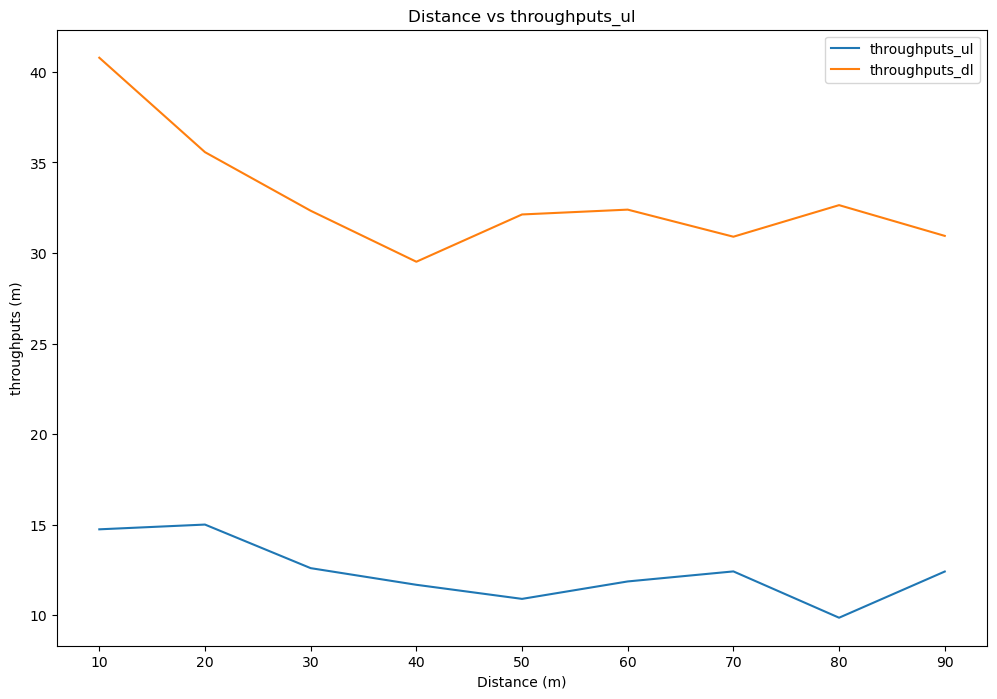

In [613]:
# Example 2 
# 10 Ue fron 10m to 100m
def Test_2():
    vehicles = {}
    distances = []
    throughputs_dl = []
    throughputs_ul = []

    for i in range(1, 10): 
        vehicles[i] = Vehicle(node_id=i, x=i*10, y=0, speed=30)

    for vehicle in vehicles.values():
        vehicle.calculate_downlink_metrics()
        vehicle.calculate_uplink_metrics()

    equal_bandwidth_allocation(vehicles.values(), total_bandwidth_dl, "downlink")
    equal_bandwidth_allocation(vehicles.values(), total_bandwidth_ul, "uplink")
    for vehicle in vehicles.values():
        vehicle.calculate_throughput()
        useful_dl = calculate_useful_throughput(vehicle.throughput_dl)
        useful_ul = calculate_useful_throughput(vehicle.throughput_ul)
        distances.append(vehicle.distance_dl)
        throughputs_dl.append(useful_dl)
        throughputs_ul.append(useful_ul)

    print(distances)
    print(throughputs_dl)
    print(throughputs_ul)

    # Plot metrics
    plt.figure(figsize=(12, 8))
    plt.plot(distances, throughputs_ul, label="throughputs_ul")
    plt.plot(distances, throughputs_dl, label="throughputs_dl")
    plt.xlabel("Distance (m)")
    plt.ylabel("throughputs (m)")
    plt.title("Distance vs throughputs_ul")
    plt.legend()
    
Test_2()



## Read input file from SUMO

In [614]:
def read_input_file(filepath):
    """
    Read mobility data from an input file.
    Each line: {timestamp} {node_id} {x} {y} {speed}

    Parameters:
        filepath (str): Path to the input file.

    Returns:
        list: Parsed input data.
    """
    data = []
    with open(filepath, "r") as file:
        for line in file:
            parts = line.strip().split()
            timestamp, node_id, x, y, speed = (
                float(parts[0]),
                int(parts[1]),
                float(parts[2]),
                float(parts[3]),
                float(parts[4]),
            )
            data.append((timestamp, node_id, x, y, speed))
    return data

## Simulation

In [ ]:
# save to an output file
def save_simulation_results_to_file(filename, vehicles, timestamp):
    with open(filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        for vehicle in vehicles.values():
            writer.writerow([
                timestamp, vehicle.node_id, vehicle.position[0], vehicle.position[1],
                vehicle.speed, vehicle.distance_dl, vehicle.distance_ul, vehicle.throughput_dl,
                vehicle.throughput_ul, vehicle.spectral_efficiency_dl, vehicle.spectral_efficiency_ul,
                vehicle.fading_dl, vehicle.fading_ul, vehicle.useful_throughput_dl, vehicle.useful_throughput_ul
            ])
            
def simulate_v2x(input_data, filename="v2x_simulation_results.csv"):
    vehicles = {}

    # Create and initialize CSV file with headers
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            "Timestamp", "Node ID", "X Position", "Y Position", "Speed", "Distance DL",
            "Distance UL", "Throughput DL", "Throughput UL", "Spectral Efficiency DL",
            "Spectral Efficiency UL", "Fading DL", "Fading UL", "Useful Throughput DL", "Throughput UL" 
        ])
    # read the input data
    for _, node_id, x, y, speed in input_data:
        if node_id not in vehicles:
            vehicles[node_id] = Vehicle(node_id, x, y, speed)

    # start the simulation
    current_time = 0.0
    for timestamp, node_id, x, y, speed in input_data:
        if timestamp > current_time:
            # TODO: This part is not optimized since I am looping several times on vehicules!!!
            for vehicle in vehicles.values():
                vehicle.calculate_downlink_metrics()
                vehicle.calculate_uplink_metrics()
            equal_bandwidth_allocation(vehicles.values(), total_bandwidth_dl, "downlink")
            proportional_bandwidth_allocation(vehicles.values(), total_bandwidth_ul, "uplink")
            for vehicle in vehicles.values():
                vehicle.calculate_throughput()                
                vehicle.useful_throughput_dl = calculate_useful_throughput(vehicle.throughput_dl)
                vehicle.useful_throughput_ul = calculate_useful_throughput(vehicle.throughput_ul)
            # save the results for all vehicules.
            save_simulation_results_to_file(filename, vehicles, timestamp)
            current_time = timestamp
        vehicles[node_id].update_position(x, y)
        vehicles[node_id].speed = speed

# Run the simulation
input_data = read_input_file("./v2x_mobility.txt")
simulate_v2x(input_data)